In [3]:
%%writefile SelfOrganizingMap.py

import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import matplotlib.patches as mpatches


# ----------------------------------------
def NeighbourhoodGaussian(distance, epoch):
    return np.exp(-1 * epoch**2 * distance**2)


# ----------------------------------------
def NeighbourhoodMexicanHat(distance, epoch):
    e_2 = epoch**2
    d_2 = distance**2
    return (1 - distance) * np.exp(-1 * e_2 * d_2)


# ===================================
class SelfOrganizingMap:

    # ----------------------------------------
    def __init__(self, width, height, features, hexagonal_map=False):
        self.width = width
        self.height = height
        self.features = features
        self.use_hexagonal_map = hexagonal_map
        self._init_map()

    # ----------------------------------------
    def _init_map(self):
        self.numbered_matrix_fields = np.unravel_index(
            np.arange(self.width * self.height).reshape(self.width,
                                                        self.height),
            (self.width, self.height))
        self.map_coords_xy = copy.deepcopy(self.numbered_matrix_fields)
        if self.use_hexagonal_map:
            cord_y = self.map_coords_xy[0]
            cord_y = cord_y.astype(float)
            cord_y = cord_y * np.sqrt(3)
            cord_y[:, (
                np.arange(self.height) *
                2)[np.arange(self.height) * 2 < self.height]] += np.sqrt(3) / 2
            cord_x = self.map_coords_xy[1]
            cord_x = cord_x.astype(float)
            cord_x = cord_x * 3 / 2
            self.map_coords_xy = (cord_y, cord_x)

    # ----------------------------------------
    def init_weights(self,
                     data=None
                    ):  # randomize if data is None else sample from data
        if data is None:
            self.weights = np.random.normal(size=(self.width, self.height,
                                                  self.features))
        else:
            size = (self.width, self.height, -1)
            selected_points = [
                data[np.random.randint(len(data))]
                for i in range(size[0] * size[1])
            ]
            self.weights = np.array(selected_points).reshape(size)

    # ----------------------------------------
    def winner_for_sample(self, sample):
        distances = np.linalg.norm(self.weights - sample, axis=2)
        return np.unravel_index(distances.argmin(), distances.shape)

    # ----------------------------------------
    def get_distances(self, winning):  # euclidean, between (i,j) and (m,n)
        return np.sqrt((self.map_coords_xy[0] -
                        self.map_coords_xy[0][winning[0], winning[1]])**2 +
                       (self.map_coords_xy[1] -
                        self.map_coords_xy[1][winning[0], winning[1]])**2)

    # ----------------------------------------
    def train(self,
              data,
              epochs,
              neighbourhood_scaler,
              learning_rate,
              distance_function=NeighbourhoodGaussian):
        rng = np.random.default_rng()
        data_copy = copy.deepcopy(data)
        for epoch in range(epochs):
            lr_current = learning_rate * np.exp(-1 * epoch / epochs)
            rng.shuffle(data_copy, axis=0)
            for data_row in data_copy:
                winning = self.winner_for_sample(data_row)
                distances_from_winning = self.get_distances(
                    winning) * neighbourhood_scaler
                self.weights += distance_function(
                    distances_from_winning, epoch).reshape(
                        self.width, self.height,
                        -1) * lr_current * (data_row - self.weights)

    # ----------------------------------------
    def plot_map(self,
                 data,
                 classes,
                 title=None,
                 ax=None,
                 symbols=True,
                 labels=None):
        max_dim = max(self.width, self.height)
        ax_original = ax
        if ax_original is None:
            fig, ax = plt.subplots(figsize=(self.width / max_dim * 5,
                                            self.height / max_dim * 5))
        else:
            ax = ax_original
        markers = ['o', 's', 'D', "P", "*", "+", 'v', '1', '3', 'p', 'x']
        colors = [
            'r', 'g', 'b', 'c', 'k', 'y', (0.9, 0.2, 0.9), (1, 0.5, 0),
            (1, 1, 0.3), "m", (0.4, 0.6, 0)
        ]
        cords_x = self.map_coords_xy[0].astype(float)
        cords_y = self.map_coords_xy[1].astype(float)
        if self.use_hexagonal_map:
            numVertices = 6
            radius = 1
            orientation = np.radians(0)
            axis_limits = [
                np.min(cords_x) - 1 / 2 * np.sqrt(3),
                np.max(cords_x) + 3 / 2 * np.sqrt(3),
                np.min(cords_y) - 1 / 2,
                np.max(cords_y) + 5 / 2
            ]
        else:
            numVertices = 4
            radius = np.sqrt(2) / 2
            orientation = np.radians(45)
            axis_limits = [0, np.max(cords_x) + 2, 0, np.max(cords_y) + 2]

        # plot empty map
        for x, y in zip(cords_x.flatten() + 1, cords_y.flatten() + 1):
            ax.add_patch(
                RegularPolygon((x, y),
                               numVertices=numVertices,
                               radius=radius,
                               orientation=orientation,
                               facecolor="white",
                               alpha=1,
                               edgecolor='k'))
            
        # count number of winning neurons from each class for every neuron
        winning_count = np.zeros(
            (self.width, self.height, len(np.unique(classes))))
        
        # plot colored map with classes markers
        for i, data_row in enumerate(data):
            w = self.winner_for_sample(data_row)
            winning_count[w[0], w[1], classes[i][0]] += 1
            if symbols:
                ax.plot(cords_x[w[0], w[1]] + 1,
                        cords_y[w[0], w[1]] + 1,
                        markers[classes[i][0]],
                        markerfacecolor='None',
                        markeredgecolor=colors[classes[i][0]],
                        markersize=12 + classes[i] * 2,
                        markeredgewidth=2)                
            ax.add_patch(
                RegularPolygon(
                    (cords_x[w[0], w[1]] + 1, cords_y[w[0], w[1]] + 1),
                    numVertices=numVertices,
                    radius=radius,
                    orientation=orientation,
                    facecolor=colors[classes[i][0]],
                    alpha=0.05,
                    edgecolor='k'))
        if labels is not None:
            # for each neuron add text with the most common winning class
            winning_class = np.argmax(winning_count, axis=2)
            for i in range(self.width):
                for j in range(self.height):
                    plt.text(self.map_coords_xy[0][i, j] + 1,
                             self.map_coords_xy[1][i, j] + 1,
                             labels[winning_class[i, j]],
                             ha='center',
                             va='center',
                             fontsize=12)
        ax.axis(axis_limits)
        if title is not None:
            ax.set_title(title)
        else:
            ax.set_title("Data represented by the Kohonen Network")
        if ax_original is None:
            plt.show()
        else:
            return

Writing SelfOrganizingMap.py


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SelfOrganizingMap as SOM
colors = ['r','g','b','c','k','y',(0.9,0.2,0.9), (1,0.5,0), (1,1,0.3), "m", (0.4,0.6,0)]

In [5]:
def compare_scalers(hexagonal_map, dataset_name):
    scalers = [0.01,0.1, 0.5, 1]
    map_sizes = [[5,5],[10,10],[30,30]]

    fig, axs = plt.subplots(4,3,figsize=(12,16))
    for i in range(4):
        for j in range(3):
            som = SOM.SelfOrganizingMap(map_sizes[j][0],map_sizes[j][1],x_train.shape[1], hexagonal_map=hexagonal_map)
            som.init_weights()
            som.train(data=x_train, epochs=10,neighbourhood_scaler=scalers[i], learning_rate=0.3)
            som.plot_map(data=x_train, classes=y_train, title=f"Scaler: {scalers[i]}, Map: {map_sizes[j][0]}x{map_sizes[j][1]}", ax=axs[i,j])

    fig.suptitle(f'Data: {dataset_name}, 10 epochs, learning rate 0.3',y=0.93,size=20)
    plt.show()

## Dataset 1: 2d simple data

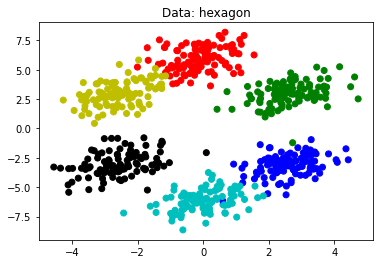

          x         y  c
0  2.402047  3.728695  1
1 -0.660032  7.047206  0
2  2.202839 -2.394303  2
3  3.179183  2.593885  1
4  3.173320 -2.152688  2


In [6]:
df_train = pd.read_csv('data/hexagon.csv')
plt.scatter(df_train['x'], df_train['y'], c=np.array(colors, dtype=object)[df_train['c']])
plt.title("Data: hexagon")
plt.show()
print(df_train.head())


x_train = df_train[["x","y"]].to_numpy()
y_train = df_train[["c"]].to_numpy()

### Map elements: squares

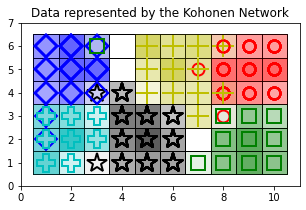

In [7]:
som = SOM.SelfOrganizingMap(10,6,2, hexagonal_map=False)
som.init_weights()
som.train(data=x_train, epochs=10,neighbourhood_scaler=0.5, learning_rate=0.3, distance_function=SOM.NeighbourhoodGaussian)
som.plot_map(data=x_train, classes=y_train)

### Map elements: hexagons

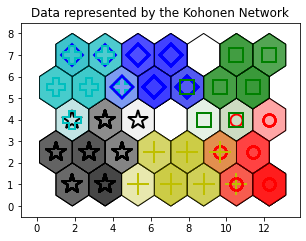

In [8]:
som = SOM.SelfOrganizingMap(7,5,2, hexagonal_map=True)
som.init_weights()
som.train(data=x_train, epochs=10,neighbourhood_scaler=0.1, learning_rate=0.3, distance_function=SOM.NeighbourhoodMexicanHat)
som.plot_map(data=x_train, classes=y_train)

### Comparison of various distance scalers

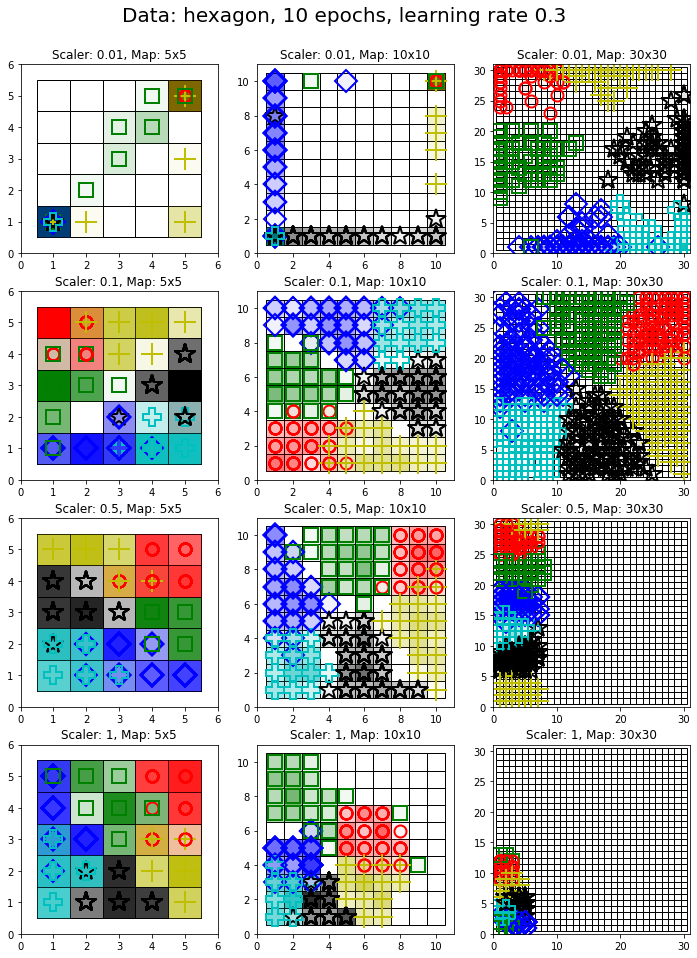

In [9]:
compare_scalers(hexagonal_map=False,dataset_name="hexagon")

## Dataset 2: 3d simple data

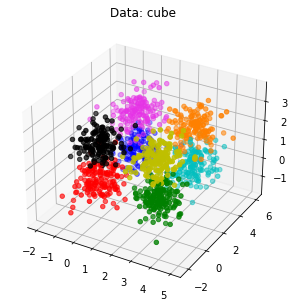

          x         y         z  c
0  0.187781  0.239537  0.382492  0
1 -1.308979 -0.143321 -0.966648  0
2 -0.987613  0.679918 -0.037552  0
3  0.924980  0.607235 -0.146856  0
4 -0.098663  0.004329 -0.588876  0


In [10]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
df_train = pd.read_csv('data/cube.csv')
ax.scatter(df_train['x'],df_train['y'],df_train['z'], c=np.array(colors, dtype=object)[df_train['c']])
plt.title("Data: cube")
plt.show()
print(df_train.head())


x_train = df_train[["x","y","z"]].to_numpy()
y_train = df_train[["c"]].to_numpy()

### Map elements: squares

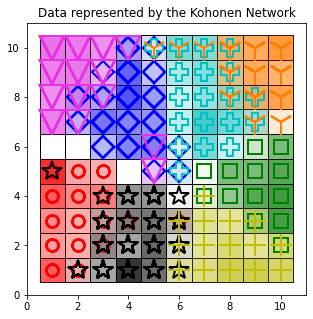

In [11]:
som = SOM.SelfOrganizingMap(10,10,3, hexagonal_map=False)
som.init_weights()
som.train(data=x_train, epochs=10,neighbourhood_scaler=0.1, learning_rate=0.3, distance_function=SOM.NeighbourhoodMexicanHat)
som.plot_map(data=x_train, classes=y_train)

### Map elements: hexagons

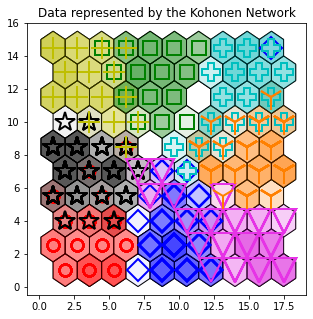

In [12]:
som = SOM.SelfOrganizingMap(10,10,3, hexagonal_map=True)
som.init_weights()
som.train(data=x_train, epochs=10,neighbourhood_scaler=0.1, learning_rate=0.3, distance_function=SOM.NeighbourhoodGaussian)
som.plot_map(data=x_train, classes=y_train)

### Comparison of various distance scalers

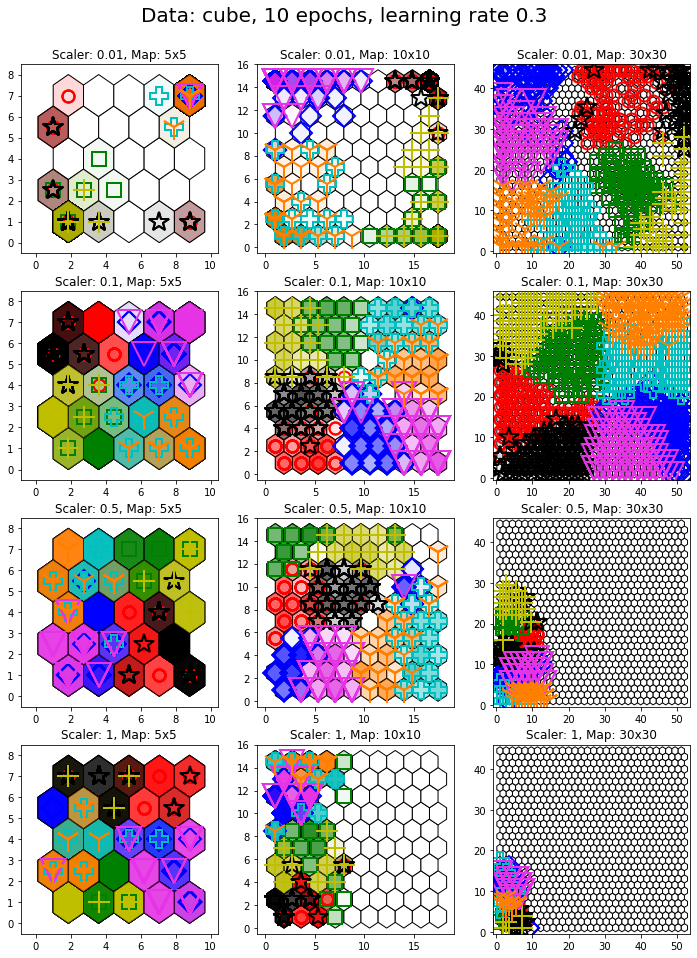

In [13]:
compare_scalers(hexagonal_map=True, dataset_name="cube")